In [1]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gb4k4p_r
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gb4k4p_r
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 29.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=37782efa22781f3aeedf18f4fdbcf218403d311a290e6ffdc19fbd77b9dc87fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-b45uhyae/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

import clip

In [4]:
CLIP_BACKBONE = "ViT-B/16"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FIGURE_SIZE = (8, 6)

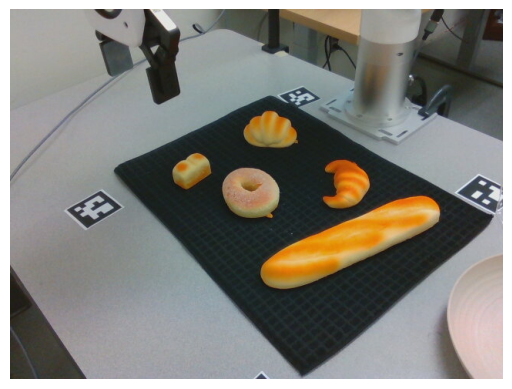

In [5]:
def fetch_image(url_or_path: str) -> Image.Image:
    if 'http' in url_or_path:
        response = requests.get(url_or_path)
        return Image.open(BytesIO(response.content)).convert("RGB")
    return Image.open(url_or_path)

IMAGE_URL = "/home/ttyh/hot3d/hot3d/dataset/images/bread.jpg"
image = fetch_image(IMAGE_URL)
plt.imshow(image)
plt.axis("off")
plt.show()

In [6]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights="DEFAULT",
)
faster_rcnn.eval()

print("Faster R-CNN model loaded successfully!")


Faster R-CNN model loaded successfully!


In [7]:
clip_model, clip_preprocess = clip.load(CLIP_BACKBONE, device=DEVICE)
print(f"CLIP model with {CLIP_BACKBONE} backbone loaded successfully!")

CLIP model with ViT-B/16 backbone loaded successfully!


In [8]:
def compute_faster_rcnn_result(image: Image.Image) -> dict:
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image_pt = transform(image)
    transformed = faster_rcnn.transform([image_pt])[0]
    features = faster_rcnn.backbone(transformed.tensors)

    all_region_proposal_boxes = faster_rcnn.rpn(transformed, features)[0][0]
    frcnn_outputs = faster_rcnn(image_pt.unsqueeze(0))[0]

    return {
        "all_region_proposal_boxes": all_region_proposal_boxes,
        "candidates": frcnn_outputs,
    }

frcnn_result = compute_faster_rcnn_result(image)
all_region_proposals = frcnn_result['all_region_proposal_boxes'].detach()
candidates_data = frcnn_result['candidates']

candidate_boxes = candidates_data['boxes'].detach()
candidate_scores = candidates_data['scores'].detach()

print(f"Total number of region proposal boxes: {all_region_proposals.shape[0]}")
print(f"Total number of candidate boxes: {candidate_boxes.shape[0]}")

Total number of region proposal boxes: 870
Total number of candidate boxes: 26


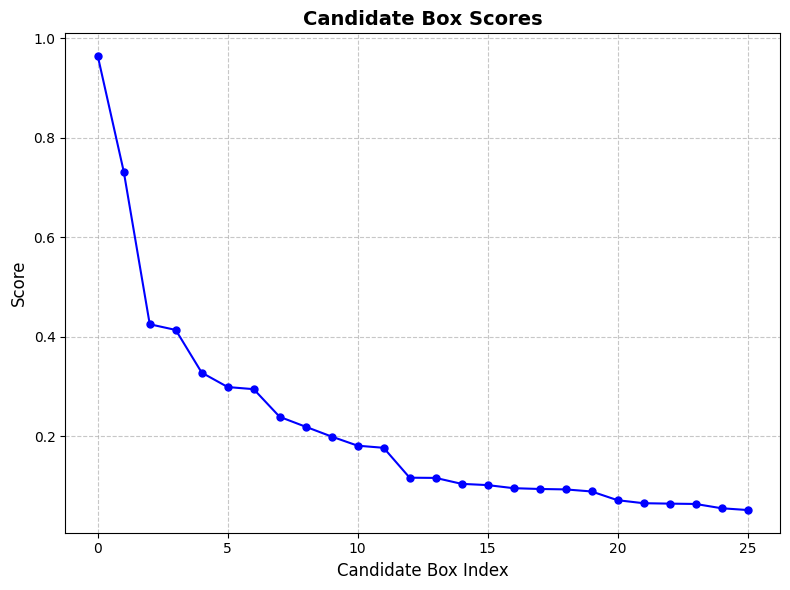

In [10]:
def plot_candidate_scores(candidate_scores: torch.Tensor) -> None:
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(candidate_scores.cpu().numpy(), marker="o", linestyle='-', color='b', markersize=5, linewidth=1.5)
    plt.xlabel("Candidate Box Index", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title("Candidate Box Scores", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    
plot_candidate_scores(candidate_scores)

In [11]:
def plot_image_with_boxes(image, boxes, labels=None, figsize=FIGURE_SIZE):
    fig, ax = plt.subplots(1, figsize=figsize)
    
    ax.imshow(image)
    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        ax.add_patch(rect)

        if labels is not None:
            label_size = len(labels[i]) * 10
            ax.text(
                x_min + (x_max - x_min) / 2 - label_size / 2,
                y_min - 10,
                labels[i],
                fontsize=12,
                verticalalignment="top",
                color="white",
                bbox=dict(facecolor="green", alpha=0.5, edgecolor="none"),
            )

    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()

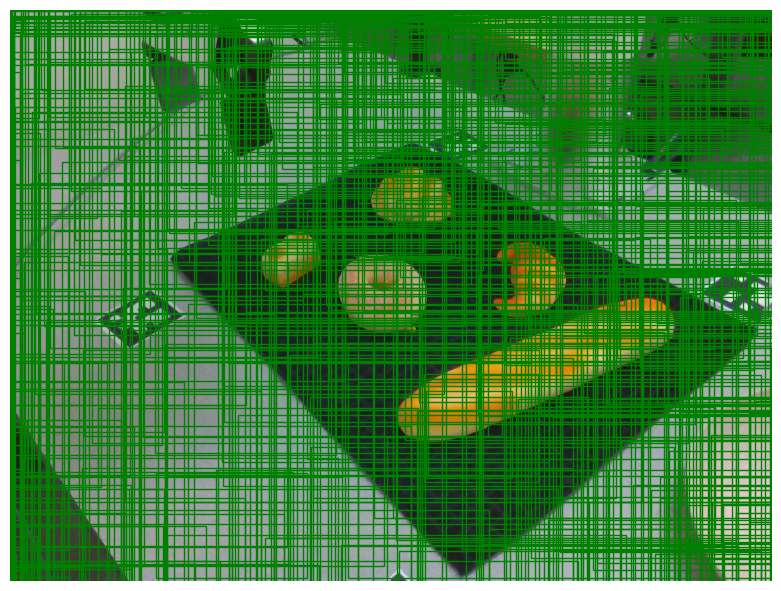

In [12]:
plot_image_with_boxes(image, all_region_proposals)

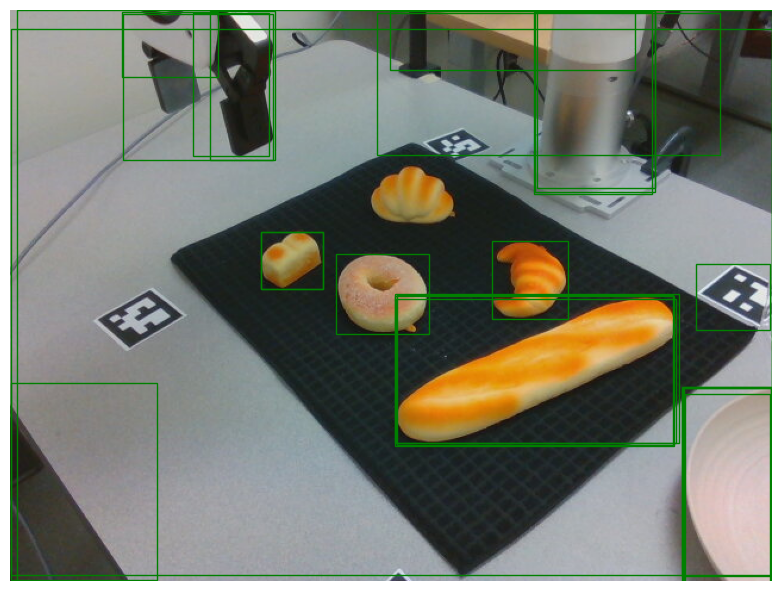

In [13]:
plot_image_with_boxes(image, candidate_boxes)

In [14]:
tensor_transform = transforms.ToTensor()
image_pt = tensor_transform(image)

In [15]:
def detect_object_coordinates(model, processor, prompts, image_pt, boxes, device=DEVICE):
    height, width = image_pt.shape[-2:]
    
    max_similarity = -np.inf
    max_rel_box = None
    model.eval()
    
    tokenized_query = clip.tokenize(prompts).to(device)
    text_features = model.encode_text(tokenized_query)
    norm_text_features = F.normalize(text_features, p=2, dim=-1).mean(dim=0, keepdim=True)

    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        x_max, y_max = min(width, x_max), min(height, y_max)

        if x_min > x_max or x_min > width or y_min > y_max or y_min > height:
            continue

        cropped_image = image_pt[:, y_min:y_max+1, x_min:x_max+1]
        if not torch.prod(torch.tensor(cropped_image.shape)):
            continue

        cropped_image = processor(transforms.functional.to_pil_image(cropped_image)).unsqueeze(0).to(device)
        
        image_features = model.encode_image(cropped_image)
        norm_image_features = F.normalize(image_features, p=2, dim=-1)

        similarity = torch.dot(norm_image_features.view(-1), norm_text_features.view(-1))
        
        if similarity > max_similarity:
            max_similarity = similarity
            max_rel_box = box
    
    return max_rel_box.cpu().numpy() if max_rel_box is not None else None

In [ ]:
labels = ['hat', 'camera', 'book', 'orange', 'drink', 'scarf']
